# 基于resnet50在CIFAR10数据集上实现图像分类

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import torch.utils.data as Data
import time
import argparse
import matplotlib.pyplot as plt
from d2l import torch as d2l

In [2]:
stats = ((0.5,0.5,0.5),(0.5,0.5,0.5))
# 将大小转化为 -1到1
# 随即垂直 水平 翻转 默认 p=0.5

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*stats)
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*stats)
])

### 数据集导入 

In [3]:
train_data = torchvision.datasets.CIFAR10(download=True, root="dataset", train=True, transform=train_transform)
test_data = torchvision.datasets.CIFAR10(download=True, root="dataset", train=False, transform=test_transform)

BATCH_SIZE = 128
train_dl = Data.DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
test_dl = Data.DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


### 数据集展示 

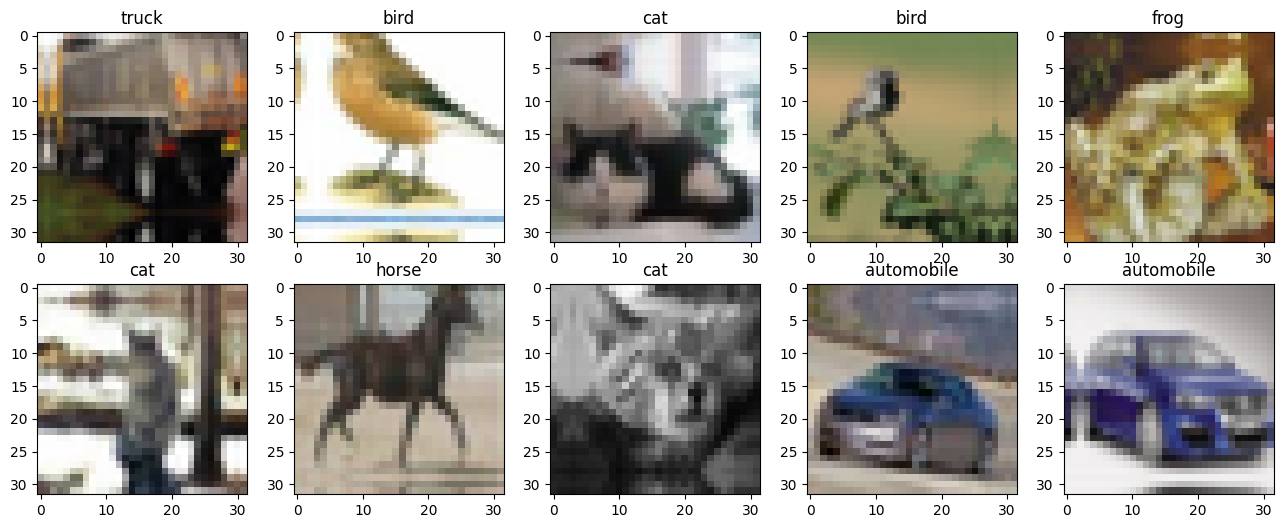

In [4]:
# for 10 images
train_10_samples = Data.DataLoader(train_data, 10, num_workers=4, pin_memory=True, shuffle=True)

dataiter = iter(train_10_samples)
images, labels = next(dataiter)

fig, axs = plt.subplots(2, 5, figsize=(16, 6))
nums = 0
for i in range(2):
    for j in range(5):
        img = images[nums] / 2 + 0.5        
        npimg = img.numpy()
        axs[i][j].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[i][j].set_title(train_data.classes[labels[nums]])
        nums += 1
plt.show()

### 图像增广 

In [5]:
def apply(img, aug, num_rows=2, num_cols=5, scale=1.5):
    Y = [aug(img).permute(1,2,0) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

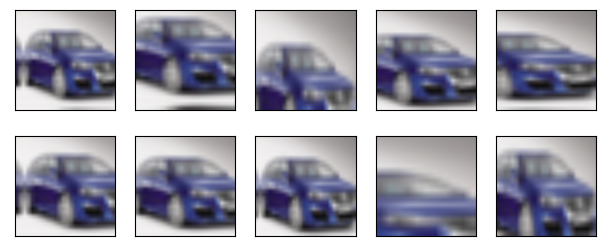

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 模型构建 

In [7]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

### 训练函数 

In [9]:
def train(epoch):
    net.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()#梯度清零
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()* inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = correct / total
    loss = epo

### 测试函数 

In [10]:
def test(epoch):
    global best_acc
    net.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            epoch_loss += loss.item()* inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = correct / total
    loss = epoch_loss / total

    print('test_loss: %.4f test_acc: %.4f '%(loss, acc), end=' ' )
    return {'loss': loss, 'acc': acc}

### 绘画函数 

In [11]:
def plot(d, mode='train', best_acc_=None):
    plt.figure(figsize=(10, 4))
    plt.suptitle('%s_curve' % mode)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    epochs = len(d['acc'])

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(epochs), d['loss'], label='loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(epochs), d['acc'], label='acc')
    if best_acc_ is not None:
        plt.scatter(best_acc_[0], best_acc_[1], c='r')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend(loc='upper left')
    plt.savefig('resnet50_cifar10_%s.jpg' % mode, bbox_inches='tight')

### 关于参数的定义 

In [14]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
args = parser.parse_args(args=[])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = ResNet50()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=args.lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)

### 训练与测试 

In [ ]:
train_info = {'loss': [], 'acc': []}
test_info = {'loss': [], 'acc': []}
for epoch in range(61):
    time1 = time.time()
    d_train = train(epoch)
    d_test = test(epoch)
    scheduler.step()
    print("%.4ss"%(time.time() - time1), end='\n')
    for k in train_info.keys():
        train_info[k].append(d_train[k])
        test_info[k].append(d_test[k])

In [ ]:
#在训练集喝测试集上的acc变化
plot(d_train)
plot(d_test)